In [12]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

In [13]:
avail_sims   = ['TNG']
path = '../regression'
zs = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])

In [14]:
class HMF_supression_Model(object):
    def __init__(self, sim):
        if sim not in avail_sims:
            raise ValueError("Requested sim, %s, is not available. Choose one of "%sim + str(avail_sims))

        self.sim = sim
        self.load_data()

    def load_data(self):
        for i in range(0, 9):
            if i == 0:
                temp = np.loadtxt(path+f'/regression_{zs[i]}.txt')
            else:
                temp = np.concatenate((temp, np.loadtxt(path+f'/regression_{zs[i]}.txt')), axis=0)
        self.Mvir_regression = temp[:, 0]
        self.sup_regression  = temp[:, 1]
        self.z_regression    = temp[:, 2]

    def predict(self, Mvir, z, a1, a2, a_node):
        z = np.array([z]*len(Mvir))

        points = np.column_stack((self.Mvir_regression, self.z_regression))  # 组合为(N, 2)的坐标点
        interpolator = LinearNDInterpolator(points, self.sup_regression)

        if np.max(Mvir/(a_node)) < np.min(self.Mvir_regression):
            raise ValueError("a_node is too large")
        elif np.min(Mvir/(a_node)) > np.max(self.Mvir_regression):
            raise ValueError("a_node is too small")

        # 计算 S1 数组
        S_temp = interpolator(np.column_stack((Mvir, z)))
        S1 = interpolator(np.column_stack((Mvir/(a_node), z)))
        S1[(Mvir/(a_node) < np.min(self.Mvir_regression))] = S1[S1 > 0][0]
        
        # 计算 C_node 和 datas_node_re
        S_node = np.max(S_temp[(Mvir>=11) & (Mvir<=13)])
        node_index = np.where(S_temp == S_node)[0][0]
        M_node_re = Mvir[node_index] * (a_node)

        # 计算满足条件的元素数量
        mask = Mvir <= M_node_re
        node_ind_re = int(np.sum(mask))

        # 更新 S1 数组
        standard1 = 1
        S1[:node_ind_re] = (S1[:node_ind_re]-standard1)*a1+1

        start = node_ind_re
        end = len(S1)

        for i in range(start, end):
            standard2 = (1-S1[:node_ind_re][-1]) / (end-start) * (i-start) + S1[:node_ind_re][-1]
            S1[i] = (S1[i]-standard2)*a2 + 1
        
        return S1, S_temp

In [15]:
model = HMF_supression_Model('TNG')
Mvir = np.arange(8, 16, 0.5)
z = 0.5
S1, S1_temp = model.predict(Mvir, z, 1, 0.9, a_node=1)

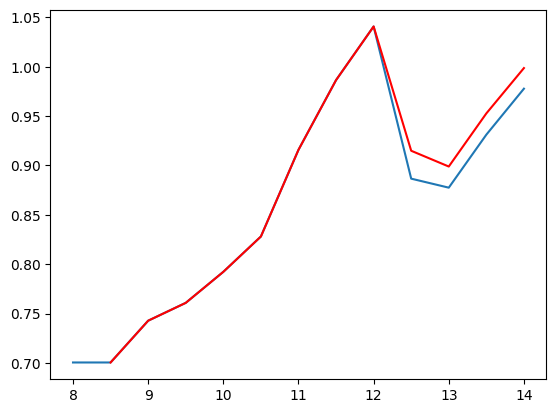

In [16]:
plt.plot(Mvir, S1, label='Linear interpolation')
plt.plot(Mvir, S1_temp, c='r')

In [17]:
for i in range(0, 9):
    if i == 0:
        temp = np.loadtxt(path+f'/regression_{zs[i]}.txt')
    else:
        temp = np.concatenate((temp, np.loadtxt(path+f'/regression_{zs[i]}.txt')), axis=0)
Mvir_regression = temp[:, 0]
sup_regression = temp[:, 1]
z_regression = temp[:, 2]

In [18]:
datas = np.arange(6,16,0.5)
z = [0.5]*len(datas)

In [19]:
points = np.column_stack((Mvir_regression, z_regression))  # 组合为(N, 2)的坐标点
interpolator = LinearNDInterpolator(points, sup_regression)

hmf1 = 0.1
hmf_node = 1.1
hmf2 = 0.3

# 假设A, B, C为一维数组，且长度相同


# 对新的A1, B1插值（支持标量或数组输入）
C_tmp = interpolator(np.column_stack((datas, z)))
C1 = interpolator(np.column_stack((datas*(hmf_node), z)))
C1[(datas*(hmf_node) < Mvir_regression.min())] = C1[C1 > 0][0]

C2 = C1.copy()

# 计算 C_node 和 datas_node_re
C_node = np.max(C_tmp[(datas>=11) & (datas<=13)])
index = np.where(C_tmp == C_node)[0][0]
datas_node_re = datas[index] / (hmf_node)

# 计算满足条件的元素数量
mask = datas <= datas_node_re
node_ind = int(np.sum(mask))

# 更新 C1 数组
standard1 = 1
C1[:node_ind] = (C1[:node_ind]-standard1)*hmf1+1

start = node_ind
end = len(C1)

for i in range(start, end):
    standard2 = (1-C1[:node_ind][-1]) / (end-start) * (i-start) + C1[:node_ind][-1]
    C1[i] = (C1[i]-standard2)*hmf2 + 1

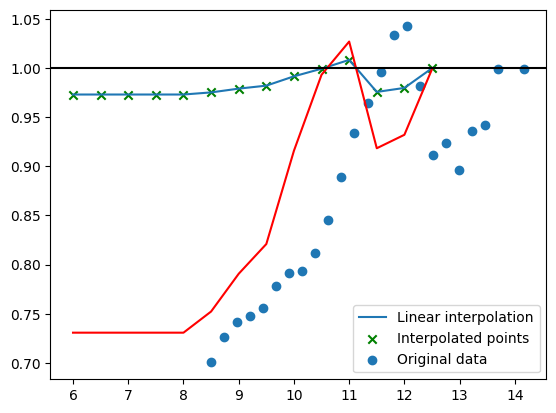

In [20]:
plt.plot(datas, C1, label='Linear interpolation')
plt.scatter(datas, C1, c='g', marker='x', label='Interpolated points')
plt.plot(datas, C2, c='r')
mask = z_regression==0.5
plt.scatter(Mvir_regression[mask], sup_regression[mask], label='Original data')
plt.axhline(y=1, c='k')
plt.legend()

In [21]:
datas[-1]

np.float64(15.5)

In [22]:
C1[-1]

np.float64(nan)